In [1]:
%reload_ext autoreload
%autoreload 2
import tensorflow as tf
import collections
import sys
import math
import numpy as np
sys.path.append('../../pytools')
import d2l
import os

d2l.gpu_mem_init()

2026-02-03 15:50:07.186969: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-03 15:50:07.248405: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-03 15:50:08.732567: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'): True


In [2]:
#@save
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """显示矩阵热图"""
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6);

I0000 00:00:1770105009.913252 1354639 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13374 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:08.0, compute capability: 7.5


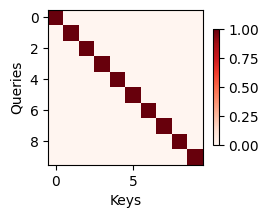

In [3]:
attention_weights = tf.reshape(tf.eye(10), (1, 1, 10, 10))
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [4]:
#@save
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return tf.nn.softmax(X, axis=-1)
    else:
        shape = X.shape
        if len(valid_lens.shape) == 1:
            valid_lens = tf.repeat(valid_lens, repeats=shape[1])

        else:
            valid_lens = tf.reshape(valid_lens, shape=-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(tf.reshape(X, shape=(-1, shape[-1])),
                              valid_lens, value=-1e6)
        return tf.nn.softmax(tf.reshape(X, shape=shape), axis=-1)

In [5]:
masked_softmax(tf.random.uniform(shape=(2, 2, 4)), tf.constant([2, 3]))

<tf.Tensor: shape=(2, 2, 4), dtype=float32, numpy=
array([[[0.3454944 , 0.65450555, 0.        , 0.        ],
        [0.53574914, 0.46425086, 0.        , 0.        ]],

       [[0.27936116, 0.4313671 , 0.28927183, 0.        ],
        [0.4366253 , 0.22233514, 0.34103957, 0.        ]]], dtype=float32)>

In [6]:
#@save
class DotProductAttention(tf.keras.layers.Layer):
    """Scaleddotproductattention."""
    def __init__(self, dropout, **kwargs):
        super().__init__(**kwargs)
        self.dropout = tf.keras.layers.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def call(self, queries, keys, values, valid_lens, **kwargs):
        d = queries.shape[-1]
        scores = tf.matmul(queries, keys, transpose_b=True)/tf.math.sqrt(
            tf.cast(d, dtype=tf.float32))
        self.attention_weights = masked_softmax(scores, valid_lens)
        return tf.matmul(self.dropout(self.attention_weights, **kwargs), values)

In [7]:
queries, keys = tf.random.normal(shape=(2, 1, 20)), tf.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = tf.repeat(tf.reshape(
    tf.range(40, dtype=tf.float32), shape=(1, 10, 4)), repeats=2, axis=0)
valid_lens = tf.constant([2, 6])

In [8]:
queries = tf.random.normal(shape=(2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention(queries, keys, values, valid_lens, training=False)

<tf.Tensor: shape=(2, 1, 4), dtype=float32, numpy=
array([[[ 2.,  3.,  4.,  5.]],

       [[10., 11., 12., 13.]]], dtype=float32)>

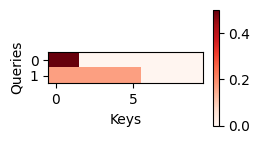

In [9]:
d2l.show_heatmaps(tf.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')